In [1]:
import os
import pandas as pd
import numpy as np
from io import StringIO
from tqdm import tqdm
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import geopandas as gpd
import pandas as pd
import pickle
from geopy.distance import geodesic # 用于计算距离
from joblib import Parallel, delayed
import sqlite3
from multiprocessing import Manager
import os
import gc
import csv
from tqdm import tqdm
import glob
import concurrent.futures

### 全数据

In [ ]:
 # 检查表是否存在
def table_exists(conn, table_name):
    query = f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'"
    result = conn.execute(query).fetchone()
    return result is not None


In [ ]:
# 将数据存入数据库，构建索引，分块提取数据
db_path  = "E:\福州.db"
point_file = r"F:\2023-04-03\part-00000-0b9e0192-156d-49b5-b24c-926a1409fad2-c000.csv"
batch_size = 3000000

# 存入数据库
conn = sqlite3.connect(db_path)
filename = os.path.basename(point_file)
chunksize = 2000000
if table_exists(conn, filename):
    print(f"表 {filename} 已存在，跳过创建")
else:
    columns_needed = ['脱敏ID', '经度', '纬度', '开始时间']
    for i, chunk in enumerate(pd.read_csv(point_file, chunksize=chunksize, usecols=columns_needed)):
        chunk.columns = ['ID', 'longitude', 'latitude', 'timestamp'] 
        if i == 0:
            chunk.to_sql(filename, conn, if_exists='replace', index=False)
        else:
            chunk.to_sql(filename, conn, if_exists='append', index=False)
        del chunk
        gc.collect()
    conn.execute(f'CREATE INDEX IF NOT EXISTS idx_id_timestamp ON `{filename}` (ID, timestamp)')
    conn.commit()

表 part-00000-0b9e0192-156d-49b5-b24c-926a1409fad2-c000.csv 已存在，跳过创建


In [6]:
def get_time_intervals(conn, filename):
    # 先读取原始数据
    df = pd.read_sql(f"SELECT ID, timestamp FROM `{filename}`", conn)
    
    # 转换为datetime类型（自动识别常见格式）
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # 计算时间差（秒）
    df['interval_seconds'] = df.groupby('ID')['timestamp'].diff().dt.total_seconds()
    
    return df.dropna(subset=['interval_seconds'])
intervals = get_time_intervals(conn, filename)
intervals

,ID,timestamp,interval_seconds
1,0000059c-50c6-481e-b384-a01d75569030,2023-04-03 08:09:21,13346.0
2,0000059c-50c6-481e-b384-a01d75569030,2023-04-03 10:14:03,7482.0
3,0000059c-50c6-481e-b384-a01d75569030,2023-04-03 10:17:58,235.0
4,0000059c-50c6-481e-b384-a01d75569030,2023-04-03 11:17:59,3601.0
5,0000059c-50c6-481e-b384-a01d75569030,2023-04-03 12:23:43,3944.0
...,...,...,...
83272046,gfkna;:4~oo4cfh96 bad5y718co72a45eb,2023-04-03 14:13:49,4703.0
83272047,gfkna;:4~oo4cfh96 bad5y718co72a45eb,2023-04-03 17:30:03,11774.0
83272048,gfkna;:4~oo4cfh96 bad5y718co72a45eb,2023-04-03 18:35:29,3926.0
83272049,gfkna;:4~oo4cfh96 bad5y718co72a45eb,2023-04-03 19:38:01,3752.0


In [ ]:
intervals['interval_minutes'] = intervals['interval_seconds'] // 60

1           222
2           125
3             4
4            60
5            66
           ... 
83272046     78
83272047    196
83272048     65
83272049     63
83272050    136
Name: interval_minutes, Length: 77015914, dtype: int32

平均值

In [9]:
intervals['interval_minutes'].mean()

79.83859017760926

In [10]:
interval_counts = intervals['interval_minutes'].value_counts()
interval_counts

interval_minutes
60      6047815
30      5977809
31      3727288
61      3139133
32      2636782
         ...   
1429          2
1430          1
1436          1
1439          1
1431          1
Name: count, Length: 1437, dtype: int64

排序

In [11]:
interval_counts.sort_index().head(20)

interval_minutes
0     560016
1     124601
2     106740
3     107249
4     109041
5      98201
6      91868
7      86668
8      84804
9      78421
10     80803
11     74024
12     76366
13     71394
14     71508
15     68344
16     68908
17     66249
18     67510
19     66485
Name: count, dtype: int64

In [12]:
interval_counts.sort_values(ascending=False).head(20)

interval_minutes
60    6047815
30    5977809
31    3727288
61    3139133
32    2636782
62    2353201
33    2061734
63    1822503
34    1787317
64    1560759
35    1476420
36    1265922
65    1261920
66    1094946
37    1054823
38     970531
67     937192
68     869365
40     852462
39     847397
Name: count, dtype: int64

<Axes: xlabel='interval_minutes'>

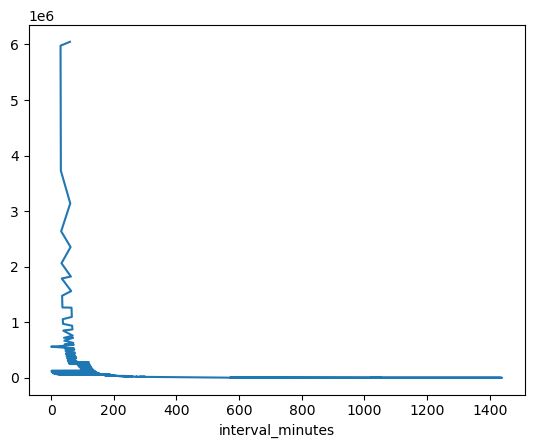

In [19]:
interval_counts.sort_values(ascending=False).plot()

In [30]:
# 统计 ≤30分钟的间隔数量（排除NaN）
count_30min = intervals[intervals['interval_minutes'] <= 100]['interval_minutes'].count()

# 总有效数据量（排除NaN）
total_count = intervals['interval_minutes'].count()

# 计算百分比
percentage = (count_30min / total_count) * 100
percentage

81.41521374400621

### 福州市

In [ ]:
# 先读取原始数据
df = pd.read_csv("F:\Timing_4_1.csv", usecols=['ID','timestamp'])

# 转换为datetime类型（自动识别常见格式）
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by=['ID', 'timestamp'])
# 计算时间差（秒）
df['interval_seconds'] = df.groupby('ID')['timestamp'].diff().dt.total_seconds()

In [ ]:
df

,ID,timestamp,interval_seconds
0,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 05:44:30,NaN
1,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 08:13:34,8944.0
2,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 09:24:35,4261.0
3,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 10:37:01,4346.0
4,00001b94-cbad-357d-a3f7-93840bd9fd6a,2023-04-01 00:22:20,NaN
...,...,...,...
18001541,ae02e0fd-b6f5-3511-bd96-70a36eb955f4,2023-04-01 19:58:56,7025.0
18001545,ae02f173-4545-417f-af98-b25,NaT,NaN
18001542,ae02f173-4545-417f-af98-b258be2595e3,2023-04-01 00:01:40,NaN
18001543,ae02f173-4545-417f-af98-b258be2595e3,2023-04-01 01:01:42,3602.0


In [ ]:
df.dropna(subset=['interval_seconds'], inplace=True)
df

,ID,timestamp,interval_seconds
1,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 08:13:34,8944.0
2,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 09:24:35,4261.0
3,00000b7d-4f1d-44dc-a5e6-535ccd67b14a,2023-04-01 10:37:01,4346.0
5,00001b94-cbad-357d-a3f7-93840bd9fd6a,2023-04-01 08:42:10,29990.0
6,00001b94-cbad-357d-a3f7-93840bd9fd6a,2023-04-01 09:12:49,1839.0
...,...,...,...
18001539,ae02e0fd-b6f5-3511-bd96-70a36eb955f4,2023-04-01 17:27:41,11566.0
18001540,ae02e0fd-b6f5-3511-bd96-70a36eb955f4,2023-04-01 18:01:51,2050.0
18001541,ae02e0fd-b6f5-3511-bd96-70a36eb955f4,2023-04-01 19:58:56,7025.0
18001543,ae02f173-4545-417f-af98-b258be2595e3,2023-04-01 01:01:42,3602.0


In [ ]:
df['interval_minutes'] = df['interval_seconds'] / 60
df['interval_minutes'].round(0).astype(int)

1           149
2            71
3            72
5           500
6            31
           ... 
18001539    193
18001540     34
18001541    117
18001543     60
18001544     86
Name: interval_minutes, Length: 16433241, dtype: int32

In [ ]:
df['interval_minutes']=df['interval_minutes'].round(0).astype(int)

In [ ]:
interval_counts = df['interval_minutes'].value_counts()
interval_counts

interval_minutes
60      1254990
30      1131542
31       761035
61       588139
32       548412
         ...   
1434          1
1420          1
1410          1
1422          1
1397          1
Name: count, Length: 1429, dtype: int64

<Axes: xlabel='interval_minutes'>

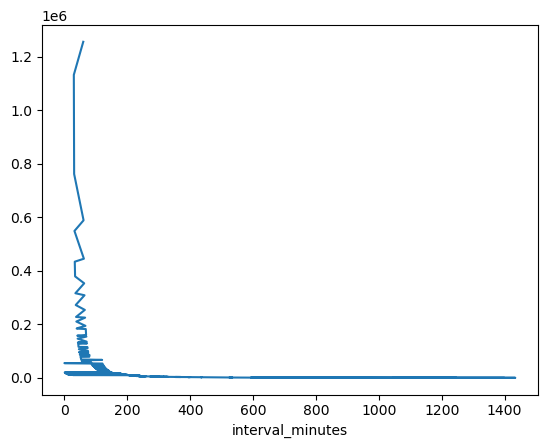

In [ ]:
interval_counts.sort_values(ascending=False).plot()

In [ ]:
df['interval_minutes'].mean()

86.91500532366075

In [ ]:
interval_counts.sort_values(ascending=False).head(20)

interval_minutes
60    1254990
30    1131542
31     761035
61     588139
32     548412
62     444683
33     433618
34     378776
63     352829
35     315794
64     308228
36     271833
65     253556
37     227216
66     224659
38     210027
67     194006
40     184748
39     183787
68     181989
Name: count, dtype: int64